# Deformation Transfer

In [ ]:
import igl
import numpy as np
import pickle

import scipy
from scipy.sparse import lil_matrix, diags, vstack
from scipy.sparse.linalg import lsqr, splu, spsolve
from scipy.spatial import cKDTree
from scipy.spatial.transform import Rotation as R

from easydict import EasyDict
from collections import defaultdict

try:
    from matplotrender import *
except:
    !pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
    
from utils.ict_face_model import ICT_face_model
from utils.util import *

import pickle
# import meshplot as mp

## Example code to create A matrix

In [1022]:
   
#V, F, INV_MAT = np.random.rand((5,3)), np.random.randint(1,5,(4,3))
NUM_V = 4
V = np.random.randint(1,6,(NUM_V,1)).repeat(3,1)
# V = np.random.randint(0,3,(3,3))
# F = np.array([[0,1,2]])
# F = np.array([[0,2,3],[1,2,5],[0,4,5]])
F = np.array([[0,1,3],[1,2,3],[0,2,3]])
# F = np.array([[0,1,2],[0,2,3],[0,3,1],[1,3,2]])

T=F.shape[0]
N=V.shape[0]
INV_MAT = np.random.randint(0,NUM_V,(T,3,3))
INV_MAT

array([[[1, 3, 2],
        [1, 1, 2],
        [3, 3, 1]],

       [[3, 2, 3],
        [3, 0, 0],
        [1, 1, 2]],

       [[0, 3, 2],
        [3, 1, 2],
        [3, 2, 3]]])

In [969]:
F

array([[0, 1, 3],
       [1, 2, 3]])

In [1026]:
# INV_MAT
COEFF = np.concatenate((
            -INV_MAT.sum(-1, keepdims=True), 
            INV_MAT
        ), axis = -1)
COEFF

array([[[-6,  1,  3,  2],
        [-4,  1,  1,  2],
        [-7,  3,  3,  1]],

       [[-8,  3,  2,  3],
        [-3,  3,  0,  0],
        [-4,  1,  1,  2]],

       [[-5,  0,  3,  2],
        [-6,  3,  1,  2],
        [-8,  3,  2,  3]]])

In [1033]:
# AA = creat_A_csr_matrix_34_adj_triangle(V, F, INV_MAT)
AA = creat_A_csr_matrix_34_small(V, F, INV_MAT)
print(F.shape[0])
print(V.shape[0])
print(AA.shape)
AA.todense()

3
4
(9, 7)


matrix([[-5.,  1.,  0.,  1.,  3.,  0.,  0.],
        [-7.,  3.,  0.,  1.,  3.,  0.,  0.],
        [-5.,  2.,  0.,  2.,  1.,  0.,  0.],
        [ 0., -7.,  3.,  3.,  0.,  1.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  1.,  0.],
        [ 0., -5.,  3.,  0.,  0.,  2.,  0.],
        [-6.,  0.,  0.,  3.,  0.,  0.,  3.],
        [-6.,  0.,  3.,  1.,  0.,  0.,  2.],
        [-7.,  0.,  2.,  2.,  0.,  0.,  3.]])

In [979]:
V

array([[3, 3, 3],
       [4, 4, 4],
       [4, 4, 4],
       [1, 1, 1]])

In [147]:
adj_list = get_adj_triangle_mat(F)
adj_list


array([[ 1., -1.],
       [-1.,  1.]])

In [989]:
# adj_list = get_adj_triangle_mat(F)
adj_list = get_adj_triangle(F)
adj_list


[[1, 2], [0, 2], [0, 1]]

In [992]:
AA = creat_A_csr_matrix_34_adj_triangle(V, F, INV_MAT)
print(AA.shape)
AA.todense()

(27, 21)


matrix([[-12.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   3.,
           0.,   0.,   6.,   0.,   0.,  -1.,   0.,   0.,  -3.,   0.,
           0.],
        [  0., -12.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,
           3.,   0.,   0.,   6.,   0.,   0.,  -1.,   0.,   0.,  -3.,
           0.],
        [  0.,   0., -12.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,
           0.,   3.,   0.,   0.,   6.,   0.,   0.,  -1.,   0.,   0.,
          -3.],
        [  1.,   0.,   0.,   8.,   0.,   0.,  -6.,   0.,   0.,   0.,
           0.,   0.,   2.,   0.,   0.,  -2.,   0.,   0.,  -3.,   0.,
           0.],
        [  0.,   1.,   0.,   0.,   8.,   0.,   0.,  -6.,   0.,   0.,
           0.,   0.,   0.,   2.,   0.,   0.,  -2.,   0.,   0.,  -3.,
           0.],
        [  0.,   0.,   1.,   0.,   0.,   8.,   0.,   0.,  -6.,   0.,
           0.,   0.,   0.,   0.,   2.,   0.,   0.,  -2.,   0.,   0.,
          -3.],
        [ -7.,   0.,   0.,   9.,   0.,   0.,  -5.,   0.,   0.,   4.,
       

In [1028]:
# AA = creat_A_csr_matrix_34_adj_triangle(V, F, INV_MAT)
AA = creat_A_csr_matrix_34(V, F, INV_MAT)
print(F)
print(V.shape)
print(AA.shape)
AA.todense()

[[0 1 3]
 [1 2 3]
 [0 2 3]]
(4, 3)
(27, 21)


matrix([[-5.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -5.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -5.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-7.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -7.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -7.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-5.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -5.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        

In [125]:
# INV_MAT
COEFF = np.concatenate((
            -INV_MAT.sum(-1, keepdims=True), 
            INV_MAT
        ), axis = -1)

rows = []
cols = []
data = []
rhs = []

def add_eq(row_coefs, rhs_val, weight):
    # row_coefs : list of (vertex_index, scalar) pairs
    # weight    : scalar weight to multiply both sides
    r = len(rhs)
    for l in range(3):
        for vid, coef in row_coefs:
            
            # x,y,z share same coef
            cols.append(3*vid+l)
            rows.append(r)
            data.append(coef*weight)
            # print(scipy.sparse.coo_matrix((data,(rows,cols)),shape=(i,3*NUM_V)).todense())
            
        rhs.append(rhs_val[l]*weight)
    
adj_list = get_adj_triangle(F)
for i, neigh in enumerate(adj_list):
    vidsi = F[i]
    inv_i = INV_MAT[i]
    for j in neigh:
        vidsj = F[j]
        inv_j = INV_MAT[j]
        # for each of 9 entries:
        for p in range(3):
            for q in range(3):
                # build equation: (sum_k [edge-coefs]_i * v~_k) - (sum_k [edge-coefs]_j * v~_k) = 0
                # where edge-coefs derive from inv_i and inv_j exactly as in identity term
                ci0 = -inv_i[q,p]*3
                ci1 = inv_i[q,p]
                ci2 = inv_i[q,p]
                cj0 = -inv_j[q,p]*3
                cj1 = inv_j[q,p]
                cj2 = inv_j[q,p]
                row_coefs = [
                    (vidsi[0],  ci0),
                    (vidsi[1],  ci1),
                    (vidsi[2],  ci2),
                    (vidsj[0], -cj0),
                    (vidsj[1], -cj1),
                    (vidsj[2], -cj2),
                ]
                # print(row_coefs)
                add_eq(row_coefs, np.zeros(3), weight=np.sqrt(1))
                # break
A = scipy.sparse.coo_matrix((data,(rows,cols)),shape=(len(rhs),3*NUM_V+3*T)).tocsr()
print(i, neigh)
# row_coefs
print(A.shape)
A.todense()
# print(INV_MAT)

1 [0]
(54, 18)


matrix([[  0.,   0.,   0.,   3.,   3.,   3.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -9.,  -9.,  -9.,   3.,   3.,   3.,   0.,   0.,   0.,   3.,
           3.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -9.,  -9.,  -9.,   3.,   3.,   3.,   0.,   0.,   0.,   3.,
           3.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0

In [ ]:
rows = []
cols = []
data = []

T = F.shape[0]
N = V.shape[0]

print("num T:", T)
print("num N:", N)

# T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
COEFF = INV_MAT.transpose(0,2,1)
# COEFF = np.concatenate((
#         -INV_MAT.sum(-1, keepdims=True), 
#         INV_MAT[:, :, 0:2]
#     ), axis = -1)

R_=3
C_=3

#VN = get_triangle_normal(V[F])

for i, H in enumerate(COEFF): # foreach T
    # H : coeff mat 3x3
    print(H)
        
    for r in range(R_):
        for c in range(C_): # foreach xyz+d
            for k, v_i in enumerate(F[i]): 
                # v_i: v indicies
                # k: num indicies (0, 1, 2)
                cols.append(C_*v_i+c)
                rows.append(9*i+R_*r+c)                
                data.append(H[r,k])
        
            # for V4 
            cols.append(3*i+C_*N+c)
            rows.append(9*i+R_*r+c)
            data.append(H[r, 3])

MAT = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))

print(MAT.todense().astype(int))
# np.savetxt('test.txt', MAT.todense().astype(int))   # X is an array
print(V.reshape(-1)[None])


num T: 2
num N: 6
[[19 17  8  8]
 [17  3 12  2]
 [11  9 13  4]]
[[ 3 12  8  0]
 [ 2 18 19  9]
 [ 6  6  7 14]]
[[19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0  0]
 [ 0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0]
 [17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0]
 [11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0 

In [12]:

F = np.array([[0,1,2],[0,2,3],[0,3,1],[1,3,2],[1,3,5]])

In [15]:
adjF = get_edge_adj_matrix(F)
# print(adjF[:3, :12])
print(adjF)
print(adjF.shape, F.shape)

[[ 3 -1 -1 -1  0]
 [-1  3 -1 -1  0]
 [-1 -1  4 -1 -1]
 [-1 -1 -1  4 -1]
 [ 0  0 -1 -1  2]]
(5, 5) (5, 3)


In [16]:
aaa = get_edge_adj_matrix(F)
print(aaa)

[[ 3 -1 -1 -1  0]
 [-1  3 -1 -1  0]
 [-1 -1  4 -1 -1]
 [-1 -1 -1  4 -1]
 [ 0  0 -1 -1  2]]


In [86]:
adjF = get_adj_triangle_mat_edge_sparse(F)
print(adjF.shape)
print(adjF[:15, :15].todense())

(36, 36)
[[ 3  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0 -1  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  3]]


### save as textfile to check if it is right!

In [246]:
np.savetxt('test.txt', A.todense())   # X is an array


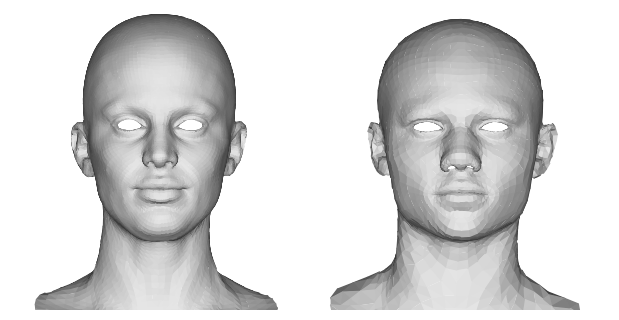

In [4]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7

srcV, srcF = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
newV, newF = igl.read_triangle_mesh("data/target_restpose_mesh.obj")

v_list=[ srcV, newV ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ srcF, newF ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [128]:
# source rest pose
V_S = get_triangle_basis(srcV, srcF)
V_S_INV = np.linalg.inv(V_S)
print(V_S_INV.shape)

As = creat_A_csr_matrix_34(srcV, srcF, V_S_INV)
print("A shape (9T x 3N+3T)", As.shape)
lu = lu_factor_ata(As)

adjM = get_adj_triangle_mat_edge_sparse(srcF)
A_Es=adjM @ As

NameError: name 'srcV' is not defined

In [6]:
# def build_smooth_optimization_term(V_span, F, adjF, A, ws=1):
V_span, F, adjF, A = V_S, srcF, adjM, As
ws=1
# num of src mesh faces
num_f = len(F)
# build a [3f, 3f] Identity matrix
id_mat_3fby3f = scipy.sparse.identity(n=9 * num_f, format='csc')
print(id_mat_3fby3f.shape)
print(adjF.shape)

# build the left-side (input) matrix of the linear equation, it's a [n, n] mat
mat_tmp = (id_mat_3fby3f - adjF).dot(A)
left_mat = (mat_tmp.transpose()).dot(mat_tmp)
# build the right-side (target) matrix of the linear equation, it's a all-zero matrix with shape [n, 3]
np_row, np_col, np_val = np.array([]), np.array([]), np.array([])
right_mat = scipy.sparse.csc_matrix((np_val, (np_row, np_col)), shape=(len(V_span), 3))
# build the weight matrix
ws_mat = scipy.sparse.identity(n=len(V_span), format='csc').multiply(2.0 * ws)
    # return left_mat, right_mat, ws_mat

(200592, 200592)
(200592, 200592)


In [7]:
left_mat.todense()

MemoryError: Unable to allocate 75.4 GiB for an array with shape (100608, 100608) and data type float64

In [96]:
left_mat, right_mat, ws_mat = build_smooth_optimization_term(V_S, srcF, adjM, As, ws=1)

ValueError: inconsistent shapes

In [49]:
# adjM = get_adj_triangle_mat(srcF)
adj = get_edge_adj_matrix(srcF)
print(adj.shape)
print(adj[0:3, :6])

(22288, 22288)
[[ 3 -1  0  0  0  0]
 [-1  3  0  0  0  0]
 [ 0  0  3  0  0  0]]


In [87]:
adjM = get_adj_triangle_mat_edge_sparse(srcF)

In [88]:
print(adjM.shape)
print(adjM[0:3, :12].todense())

(200592, 200592)
[[ 3  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  3  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  3  0  0  0  0  0  0  0  0 -1]]


In [89]:
A_Es=adjM @ As

In [90]:
A_Es.shape

(200592, 100608)

## Load meshes

In [ ]:
## loading blendshape
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS0 = 27
# BS0 = 26
BS1 = 5
print(blendshapes.shape)


tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
# src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
# src_mesh.v, src_mesh.f = ict.neutral_verts, ict.faces
print('\t src vertices:', src_mesh.v.shape, '\t faces:', src_mesh.f.shape) # (11248, 3) (22288, 3)

# src_mesh.motions = blendshapes[BS]#np.load(r'_tmp\040.npy')
# src_mesh.motions = blendshapes[BS0]+blendshapes[BS1]#np.load(r'_tmp\040.npy')
tmpv, tmpf = igl.read_triangle_mesh("data/source_deformed_mesh.obj")
src_mesh.motions = tmpv - src_mesh.v
print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)


with open("data/corrIdx_normalized_wrt_target.txt", 'rb') as f:
    corrIndices = pickle.load(f)
corrIndices = np.array(corrIndices)
print(len(corrIndices), corrIndices.min(), corrIndices.max())

# newV, newF = igl.read_triangle_mesh("_tmp/m02_deformed-0.2.obj")
# newV, newF = igl.read_triangle_mesh("data/m02_deformed-0.2.obj")
newV, newF = igl.read_triangle_mesh("data/target_restpose_mesh.obj")
newV = rescale(newV, src_mesh.v)
R0 = np.eye(3)
M_SCALE=1
M_DESCALE=1/M_SCALE
trns = np.array([0,1,0])
newV=newV*M_SCALE
# newV, R0 = random_rotate_points(newV, return_rot=True)
# newV=newV+trns


tgt_mesh.v = newV
tgt_mesh.f = newF
print('\t tgt vertices:', tgt_mesh.v.shape, '\t faces:', tgt_mesh.f.shape) # (219, 11248, 3)

(53, 11248, 3)
loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 src vertices (posed): (11248, 3)
7007 3 22278
	 tgt vertices: (3694, 3) 	 faces: (7007, 3)


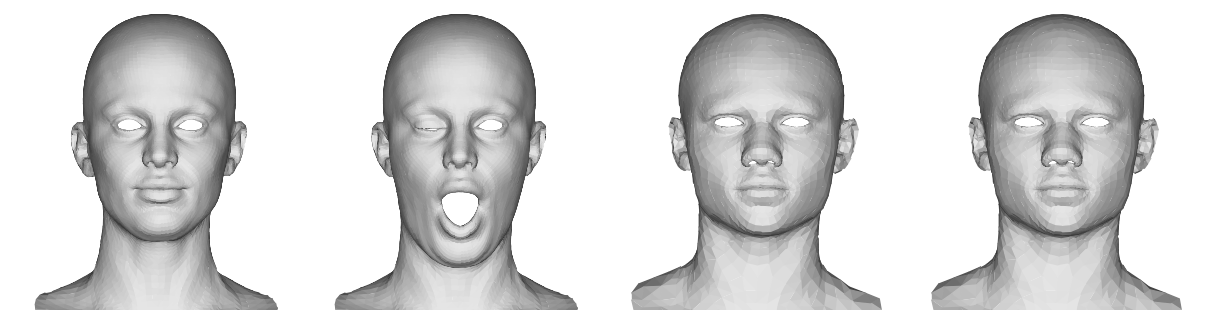

In [73]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7

# mesh that you wanna render src_mesh.v, src_mesh.f
# v_list=[ src_mesh.v, src_mesh.motions[FRAME], tgt_mesh.v, V_transferred-V_transferred.mean(0)+tgt_mesh.v.mean(0)]
v_list=[ src_mesh.v, src_mesh.motions+src_mesh.v, tgt_mesh.v, np.matmul(tgt_mesh.v, R0.T)*M_DESCALE]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ src_mesh.f, src_mesh.f,tgt_mesh.f, tgt_mesh.f ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade',bg_black=True)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [63]:
# target rest pose
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)

A = creat_A_csr_matrix_34_small(tgt_mesh.v, tgt_mesh.f, V_T_INV)
# A = creat_A_csr_matrix(tgt_mesh.v, tgt_mesh.f, V_T_INV)
print("A shape", A.shape)
lu = lu_factor_ata(A)

(7007, 3, 3)
A shape (21021, 10701)


## Run

In [64]:
# source rest pose ########################
# V_S = get_triangle_basis(src_mesh.v, src_mesh.f)
V_S = get_triangle_basis(src_mesh.v, src_mesh.f[F_idx])
# V_S = get_triangle_basis(src_mesh.v, src_mesh.f[corrIndices])
# V_S = get_triangle_basis(src_mesh.v, src_mesh.f[closest_tri])
print(V_S.shape) # (22288, 3, 3)
###########################################

# source posed ############################
#FRAME = 150
# V_S_H = get_triangle_basis(src_mesh.motions[FRAME], src_mesh.f)
# BS = 11
BS = 26
# V_S_H = get_triangle_basis(blendshapes[BS]+src_mesh.v, src_mesh.f)
V_S_H = get_triangle_basis(src_mesh.motions+src_mesh.v, src_mesh.f[F_idx])
# V_S_H = get_triangle_basis(src_mesh.motions+src_mesh.v, src_mesh.f[corrIndices])
print(V_S_H.shape) # (22288, 3, 3)
###########################################

## a.k.a source transformation `S = V^~ @ V^-1`
V_S_INV = np.linalg.inv(V_S)
S = V_S_H @ V_S_INV
print(S.shape) # (22288, 3, 3)
###########################################


# target rest pose ########################
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)
###########################################


# A^T A x^~ = A^T c
# x^~ = (A^T A)^-1 A^T c

# Atb = A.T @ S.transpose(0,2,1).reshape(-1)
Atb = A.T @ S.transpose(0,2,1).reshape(-1, 3)
print(S.shape)
print(Atb.shape)

V_transferred = lu.solve(Atb)#.reshape(-1,3)
V_transferred = V_transferred[:tgt_mesh.v.shape[0]]
print(V_transferred.shape)

recenter = -V_transferred.mean(0)+tgt_mesh.v.mean(0)


(7007, 3, 3)
(7007, 3, 3)
(7007, 3, 3)
(7007, 3, 3)
(7007, 3, 3)
(10701, 3)
(3694, 3)


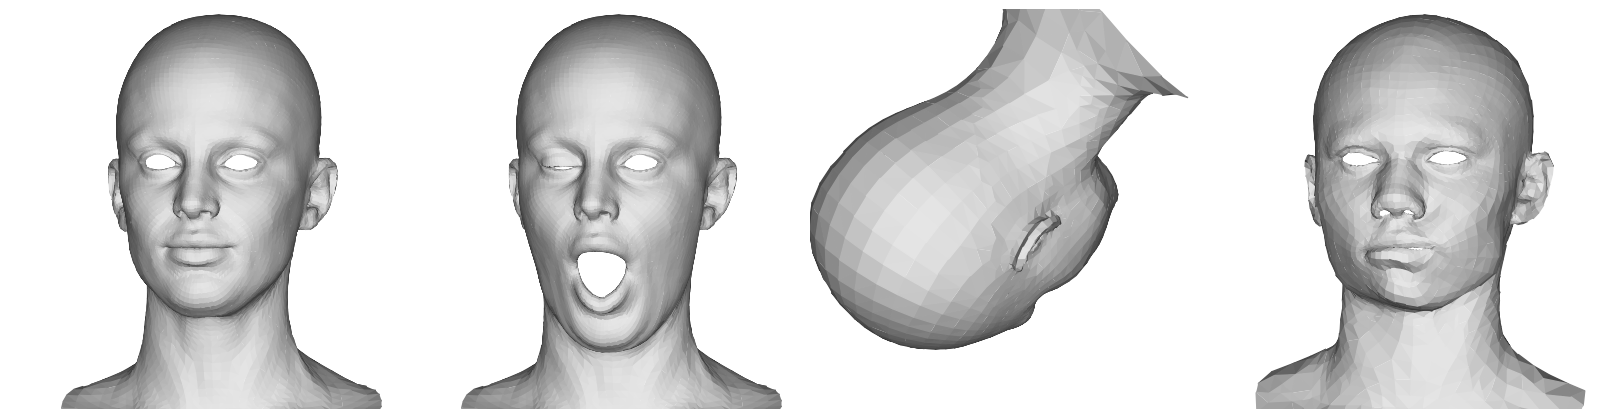

In [65]:
from matplotrender import *
# figure size
SIZE = 4
mesh_scale = .7

# mesh that you wanna render src_mesh.v, src_mesh.f
#v_list=[ src_mesh.v, src_mesh.motions[FRAME], tgt_mesh.v, V_transferred-V_transferred.mean(0)+tgt_mesh.v.mean(0)]
v_list=[ 
    src_mesh.v, 
    src_mesh.motions+src_mesh.v, 
    tgt_mesh.v, 
    # V_transferred+recenter, 
    # np.matmul(tgt_mesh.v, R0.T)*M_DESCALE-trns,
    np.matmul(V_transferred+recenter, R0.T)*M_DESCALE#-trns
]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ src_mesh.f, src_mesh.f, tgt_mesh.f, tgt_mesh.f, tgt_mesh.f, tgt_mesh.f ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,-10,0] ]*len(v_list)
# rot_list=[ [0,-10,0] ]*2+[ [43,-90,130] ]*2

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade',bg_black=True)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

# Correspondence

In [ ]:
# markers
src_m = np.array(
    [
        1225,  1888,  1052,   367,  1719,  1722,  2199,  1447,   966,
        3661,  4390,  3927,  3924,  2608,  3272,  4088,  3443,   268,
         493,  1914,  2044,  1401,  3615,  4240,  4114,  2734,  2509,
         978,  4527,  4942,  4857,  1140,  2075,  1147,  4269,  3360,
        1507,  1542,  1537,  1528,  1518,  1511,  3742,  3751,  3756,
        3721,  3725,  3732,  5708,  5695,  2081,     0,  4275,  6200,
        6213,  6346,  6461,  5518,  5957,  5841,  5702,  5711,  5533,
        6216,  6207,  6470,  5517,  5966, 10760, 11064, 10678, 10527,
        3607,  9584,  7571,  6844, 10295,  9461
    ]
)
tgt_m = np.array(
    [
        449,  475,  131,  114,  296,  649,  310,  551,  357, 1342, 1111,
       1438, 1096,  931,  949, 1263, 1253,  368,  379,  152,   40,  714,
       1497,  848,  969, 1176,  841,  361, 1618, 1723, 1707,  440,  745,
          3, 1231, 1229,  193,  384,  224,  337,  212,  326,  849, 1028,
       1070, 1002, 1125, 1018, 1931,   57,  742,    0, 1526,  865, 2049,
       2083, 2109, 2100, 1976, 1952, 1914, 1918, 1867, 2036, 2034, 2111,
       1863, 1973, 3523, 3641, 3473, 3422, 1322, 3301, 2684, 2174, 3361,
       3145
    ]
)

# np.array(src_m)

## Run

In [ ]:
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=2, Ws=0.00037, Wi=0.001, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=2, Ws=1, Wi=1, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0, Wc=0, Wm=1, show=True)
mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0.001, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=0.1, Wi=0.01, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=0.01, Wi=0.01, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=0.02, Wi=0.008, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=0.001, Wi=0.1, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=0, Wi=1, Wc=0, Wm=1, show=True)

# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=2, Ws=1, Wi=0.001, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=2, Ws=1, Wi=0.01, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=2, Ws=0, Wi=0.001, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=2, Ws=0, Wi=0.1, Wc=0, Wm=1, show=True)
# mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=2, Ws=0.001, Wi=1, Wc=0, Wm=1, show=True)

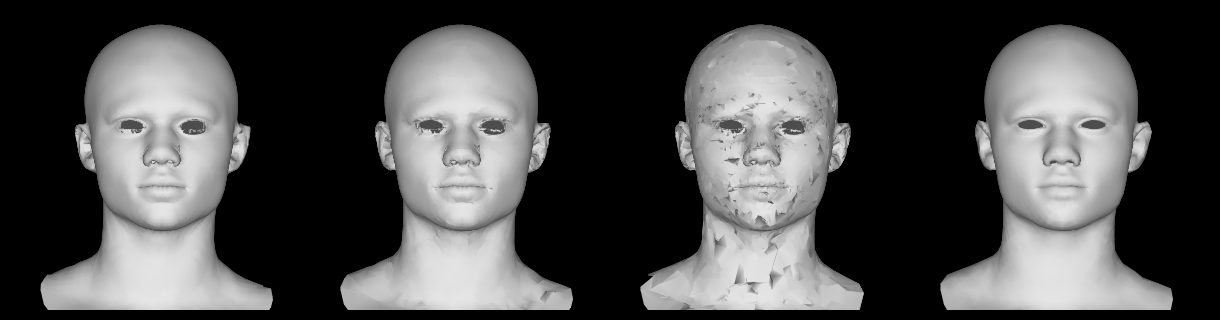

In [17]:
k=10
closest_pts0 = find_closest_valid_points(V_src=mesh.v, F_src=mesh.f, V_tar=tgt_mesh.v, F_tar=tgt_mesh.f, normal_weight=0.0, k=k)
closest_pts1 = find_closest_valid_points(V_src=mesh.v, F_src=mesh.f, V_tar=tgt_mesh.v, F_tar=tgt_mesh.f, normal_weight=0.5, k=k)
closest_pts2 = find_closest_valid_points(V_src=mesh.v, F_src=mesh.f, V_tar=tgt_mesh.v, F_tar=tgt_mesh.f, normal_weight=1, k=k)
# closest_pts.shape
mesh_scale = .65
rot_list=[ [0,0,0] ]*len(v_list)

v_list1=[ 
        closest_pts0,
        closest_pts1,
        closest_pts2,
        tgt_mesh.v,
    ]
f_list1=[ 
        src_mesh.f,
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
    ]
plot_mesh_gouraud(v_list1, f_list1, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [ ]:

# mesh = corr_system(mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0.001, Wc=1, Wm=1, show=True)
mesh = corr_system(mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0.001, Wc=1660, Wm=1, show=True)
mesh = corr_system(mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0.001, Wc=3330, Wm=1, show=True)
mesh = corr_system(mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0.001, Wc=5000, Wm=1, show=True)

# Deformation Transfer using igl library
But more like delta transfer..?

In [92]:

import igl
import numpy as np
import scipy.sparse.linalg as spla
from scipy.sparse import csr_array, csr_matrix, diags, vstack, hstack
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import splu
from utils.ict_face_model import ICT_face_model
from easydict import EasyDict

tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
# src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
src_mesh.v, src_mesh.f = igl.read_triangle_mesh(r"data/source_restpose_mesh.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:',src_mesh.f.shape) # (11248, 3) (22288, 3)

# # src_mesh.motions = np.load(r'_tmp\040.npy')
# src_mesh.motions = igl.read_triangle_mesh(r"data\source_deformed_mesh.obj")[0][None]
# print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS = 27
src_mesh.motions = blendshapes[BS]#np.load(r'_tmp\040.npy')

newV, newF = igl.read_triangle_mesh("data/m02_deformed-0.2.obj")
# newV, newF = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")
# newV, newF = igl.read_triangle_mesh("../002_mesh.obj")
newV = rescale(newV, src_mesh.v)

tgt_mesh.v = newV
tgt_mesh.f = newF
print('\t tgt vertices:', tgt_mesh.v.shape) # (219, 11248, 3)

ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
print(blendshapes.shape)

loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 tgt vertices: (11248, 3)
(53, 11248, 3)


Laplacian operator can be expressed as
$$

## Precomputes

In [ ]:
# source ###############
S_G = igl.grad(src_mesh.v, src_mesh.f) # sparse matrix
S_M = igl.massmatrix(src_mesh.v, src_mesh.f)
S_A = mesh_area(src_mesh.v, src_mesh.f)
L_S = S_G.T @ S_A @ S_G                # Approx. Laplacian
print(L_S.shape)
# L_S = S_G.T @ S_G                      # Approx. Laplacian
S_N = igl.per_vertex_normals(src_mesh.v, src_mesh.f)

# target ###############
T_G = igl.grad(tgt_mesh.v, tgt_mesh.f) # sparse matrix
T_M = igl.massmatrix(tgt_mesh.v, tgt_mesh.f)
T_A = mesh_area(src_mesh.v, src_mesh.f)
L_T = T_G.T @ T_A @ T_G                 # Approx. Laplacian
print(L_T.shape)
# L_T = T_G.T @ T_G                      # Approx. Laplacian
T_N = igl.per_vertex_normals(tgt_mesh.v, tgt_mesh.f)

T_M_I=spla.inv(T_M)
S_M_I=spla.inv(S_M)


(11248, 11248)
(11248, 11248)


## RUN

In [98]:
#FRAME=150
BS = 11
# BS = 26
BShape = blendshapes[11] + blendshapes[26]
# displacement ###############
D_S = (S_M @ T_M_I) @ (BShape)
# D_S = (src_mesh.motions[FRAME] - src_mesh.v)
# D_S = (S_M @ T_M_I) @ (BShape+src_mesh.v - S_N)
#D_S = (S_M @ T_M_I) @ ((BShape+src_mesh.v) @ R.T - src_mesh.v) 
# D_S = ((BShape+src_mesh.v) @ R.T - src_mesh.v) 
# D_S = BShape #@ R.T
# D_S = blendshapes[BS]

# solve displacement!
b = L_S @ D_S
A = L_T
# ATA = A.T @ A

x = spla.spsolve(A, b)

# scale
# x = (S_M @ T_M_I) @ x

In [100]:
print(b.shape, D_S.shape, src_mesh.v.shape)

(11248, 3) (11248, 3) (11248, 3)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


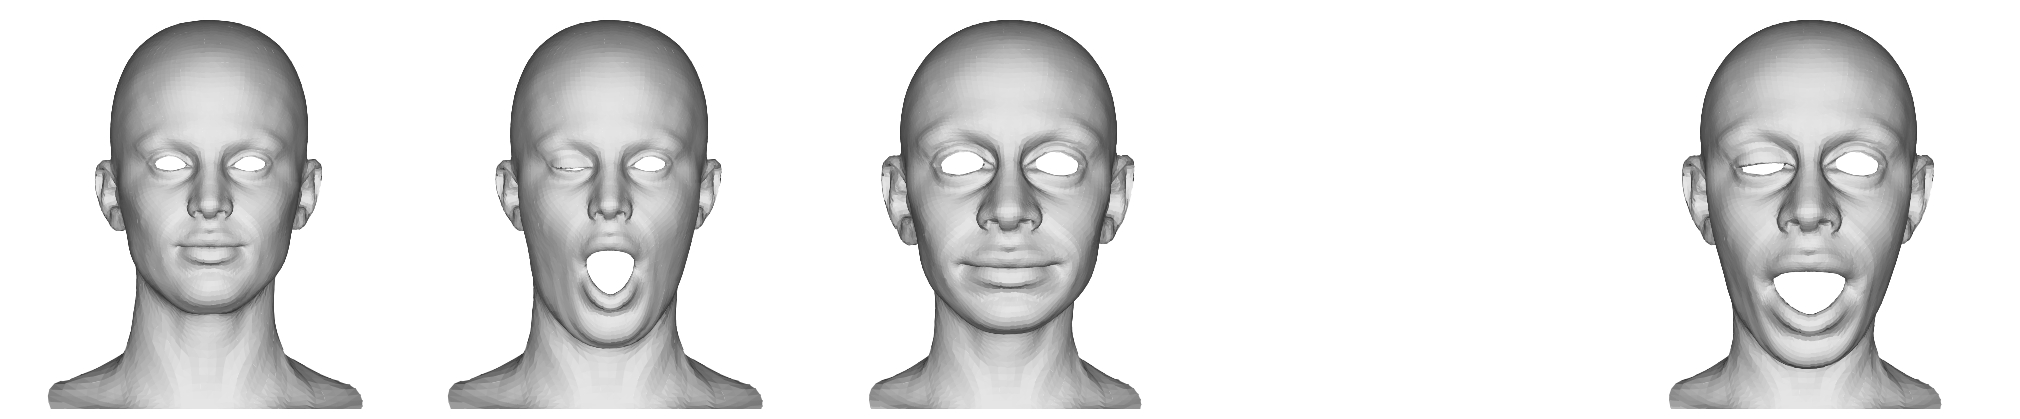

In [102]:
%load_ext autoreload
%autoreload 2
from matplotrender import plot_mesh_image
# figure size
SIZE = 4
mesh_scale = 0.68
# mesh_scale=1.2

# mesh that you wanna render
v_list=[ 
        src_mesh.v, 
        # src_mesh.motions[FRAME], 
        src_mesh.v + BShape,
        tgt_mesh.v, 
        x + tgt_mesh.v, 
        # (x-x.mean(0)) + tgt_mesh.v, 
        # (T_M_I @ S_M @ x) + tgt_mesh.v,
        # (S_M_I @ T_M @ x) + tgt_mesh.v,
        # tgt_mesh.v + (S_M @ T_M_I) @ BShape,
        tgt_mesh.v + BShape,
        # x_new,
        # x_bc, 
        # x_bc_new
    ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ 
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
    ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')